### Libraries

In [1]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import simpy
import xarray as xr

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock_new as lock_module
from opentnsim import energy as energy_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module
from opentnsim import zeesluisformulering as ZSF
from netCDF4 import Dataset
import datetime
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import folium
from shapely.ops import nearest_points, linemerge, split, snap, transform
import pyproj
import re
path = os.getcwd()

### Simulation

In [2]:
env = simpy.Environment()
t_start = datetime.datetime(2025, 1, 1, 0, 0, 0)
t_stop = datetime.datetime(2026, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())
env.epoch = t_start
env.simulation_start = t_start
env.simulation_stop = t_stop

### Network

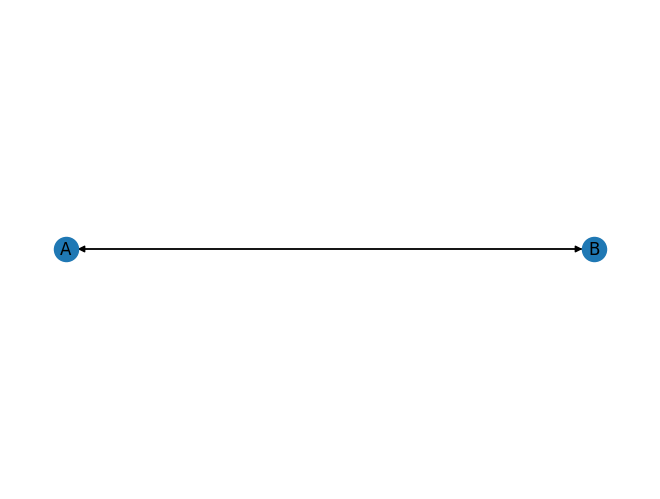

In [3]:
wgs84eqd = pyproj.CRS('4087')
wgs84rad = pyproj.CRS('4326')
wgs84eqd_to_wgs84rad = pyproj.transformer.Transformer.from_crs(wgs84eqd,wgs84rad,always_xy=True).transform
wgs84rad_to_wgs84eqd = pyproj.transformer.Transformer.from_crs(wgs84rad,wgs84eqd,always_xy=True).transform

graph = nx.MultiDiGraph()
graph.add_node('A',geometry=transform(wgs84eqd_to_wgs84rad,Point(-5000,0)))
graph.add_node('B',geometry=transform(wgs84eqd_to_wgs84rad,Point(5000,0)))
graph.add_edge('A','B',geometry=transform(wgs84eqd_to_wgs84rad,LineString([Point(-5000,0),Point(5000,0)])),length=10000)
graph.add_edge('B','A',geometry=transform(wgs84eqd_to_wgs84rad,LineString([Point(5000,0),Point(-5000,0)])),length=10000)
pos = {edge:(point.x,point.y) for edge,point in nx.get_node_attributes(graph, 'geometry').items()}
nx.draw(graph,pos,with_labels=True)
env.FG = graph

### Vessel traffic services

In [4]:
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(FG=graph)

### Lock object

In [5]:
lock = lock_module.IsLockComplex(env=env,
                                 name='Lock',
                                 node_A = 'A',
                                 node_B = 'B',
                                 node_open = 'A' #optional but required for the test
                                )

4900.0 0


### Vessels

In [6]:
Vessel = type('Vessel',(energy_module.ConsumesEnergy,lock_module.PassesLockComplex,vessel_module.IsVessel,),{}) 

In [7]:
vessel_1 = Vessel(**{"env": env,
                     "name": 'Vessel 1',
                     "origin": 'A',
                     "destination": 'B',
                     "type": 'tanker',
                     "bound": 'outbound',
                     "L": 100,
                     "B": 20,
                     "T": 10,
                     "v": 4,
                     "P_installed": 50000*1000,
                     "C_year": 2010,
                     "L_w":3,
                     "arrival_time": pd.Timestamp('2025-01-01 00:00:00')})
vessel_1.process = env.process(vessel_1.move())

vessels = []
vessels.append(vessel_1)

### Run model

In [8]:
env.run()

,bound,L,B,T,operation_index,time_of_registration,time_of_acceptance,time_arrival_at_waiting_area,time_arrival_at_lineup_area,time_lock_passing_start,time_lock_entry_start,time_lock_entry_stop,time_lock_departure_start,time_lock_departure_stop,time_lock_passing_stop,delay,time_potential_lock_door_opening_stop,time_potential_lock_door_closure_start
id,,,,,,,,,,,,,,,,,,
c2b3858d-4503-49ab-a5b3-d30dfce9439f,0,100,20,10,0,2025-01-01 00:00:00,2025-01-01 00:00:00,2025-01-01 00:20:25,NaN,2025-01-01 00:18:20,2025-01-01 00:20:25,2025-01-01 00:22:50.788337058,2025-01-01 00:42:50.788337058,2025-01-01 00:43:39.384449410,2025-01-01 00:45:44.384449410,0 days,2025-01-01 00:17:00,2025-01-01 00:22:13.596112352


,bound,vessels,capacity_L,capacity_B,time_potential_lock_door_opening_stop,time_operation_start,time_entry_start,time_entry_stop,time_door_closing_start,time_door_closing_stop,...,time_door_opening_stop,time_departure_start,time_departure_stop,time_operation_stop,time_potential_lock_door_closure_start,wlev_A,wlev_B,maximum_individual_delay,total_delay,status
lock_operation,,,,,,,,,,,,,,,,,,,,,
0,0,[<__main__.Vessel object at 0x000001864042F490>],100.0,10.0,2025-01-01 00:17:00,2025-01-01 00:18:20,2025-01-01 00:20:25,2025-01-01 00:22:50.788337058,2025-01-01 00:22:50.788337058,2025-01-01 00:27:50.788337058,...,2025-01-01 00:42:50.788337058,2025-01-01 00:42:50.788337058,2025-01-01 00:43:39.384449410,2025-01-01 00:45:44.384449410,2025-01-01 00:44:51.884449410,NaN,NaN,0 days 00:00:00,0 days 00:00:00,ready


0.0 4


In [9]:
lock_df = pd.DataFrame(lock.logbook)
vessel_df1 = pd.DataFrame(vessel_1.logbook)

In [19]:
def test_results():
    #Testing time that vessel enters the lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_entry_start.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df1.loc[4].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    #Testing time that vessel stops in the lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_entry_stop.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df1.loc[6].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_closing_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[0].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_closing_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[1].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock is levelling start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_levelling_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[2].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock is levelling stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_levelling_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[3].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is opening start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_opening_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[4].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_opening_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[5].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that vessel is starting to sail out of lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_departure_start.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df1.loc[9].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that vessel is has sailed out of lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_departure_stop.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df1.loc[10].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    np.testing.assert_equal(len(lock_df),6)
    assert 1 == 1

In [18]:
vessel_speed_data = pickle.load(open(path + '\\speed_data\\speed_data_test.pkl','rb'))
all_times = []
all_distances = []
lock_edge_geometry = transform(wgs84rad_to_wgs84eqd,graph.edges['A','B',0]['geometry'])
for vessel in vessels:
    times = []
    distances = []
    vessel_df = pd.DataFrame(vessel.logbook)
    vessel_df['Geometry'] = vessel_df['Geometry'].apply(lambda x: transform(wgs84rad_to_wgs84eqd,x))  
    for index,message_info in vessel_df.iterrows():
        time = message_info.Timestamp
        distance = lock_edge_geometry.line_locate_point(message_info.Geometry)-lock_edge_geometry.length/2
        origin = message_info.Value['origin']
        destination = message_info.Value['destination']
        edge_length = env.FG.edges[origin,destination,0]['length']
        direction = 0
        if origin != lock.start_node:
            direction = 1
        if message_info.Message == 'Sailing to first lock doors stop':   
            v0 = vessel_speed_data[vessel_speed_data.index == (origin,destination,0)].iloc[0].Speed
            v_target = lock.sailing_in_speed
            if lock.P_used_to_break_before_lock is not None:
                output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_break_before_lock,h0=17,v0=v0)
                if not direction:
                    distances_from_end = -1*(np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                    distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                    times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
                else:
                    distances_from_end = (np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                    distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                    times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
                times.extend(times_slowing_down) 
                distances.extend(distances_slowing_down)
            times.append(time)
            distances.append(distance)
        elif message_info.Message == 'Sailing to position in lock stop':
            v0 = lock.sailing_in_speed
            v_target = 0.1
            if lock.P_used_to_break_in_lock is not None:
                output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_break_in_lock,h0=lock.lock_depth,v0=v0)
                if not direction:
                    distances_from_end = -1*(np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                    distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                    times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
                else:
                    distances_from_end = (np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                    distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                    times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
                times.extend(times_slowing_down) 
                distances.extend(distances_slowing_down)
            times.append(time)
            distances.append(distance)
        elif message_info.Message == 'Sailing to second lock doors start':
            times.append(time)
            distances.append(distance)
            v0 = 0.1
            v_target = lock.sailing_out_speed
            if lock.P_used_to_accelerate_in_lock is not None:
                output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_accelerate_in_lock,h0=lock.lock_depth,v0=v0)
                if not direction:
                    distances_from_start = np.append(np.array(0),np.array(output['distance']))
                    distances_accelerating = distance+distances_from_start
                    times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
                else:
                    distances_from_start = -1*np.append(np.array(0),np.array(output['distance']))
                    distances_accelerating = distance+distances_from_start
                    times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
                times.extend(times_accelerating) 
                distances.extend(distances_accelerating)
        elif message_info.Message == 'Sailing to lock complex exit start':
            times.append(time)
            distances.append(distance)
            v0 = lock.sailing_out_speed
            v_target = vessel_speed_data[vessel_speed_data.index == (origin,destination,0)].iloc[0].Speed
            if lock.P_used_to_accelerate_after_lock is not None:
                output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_accelerate_after_lock,h0=17,v0=v0)
                if not direction:
                    distances_from_start = np.append(np.array(0),np.array(output['distance']))
                    distances_accelerating = distance+distances_from_start
                    times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
                else:
                    distances_from_start = -1*np.append(np.array(0),np.array(output['distance']))
                    distances_accelerating = distance+distances_from_start
                    times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
                times.extend(times_accelerating) 
                distances.extend(distances_accelerating)
        else:
            times.append(time)
            distances.append(distance)
            
    all_times.append(times)
    all_distances.append(distances)

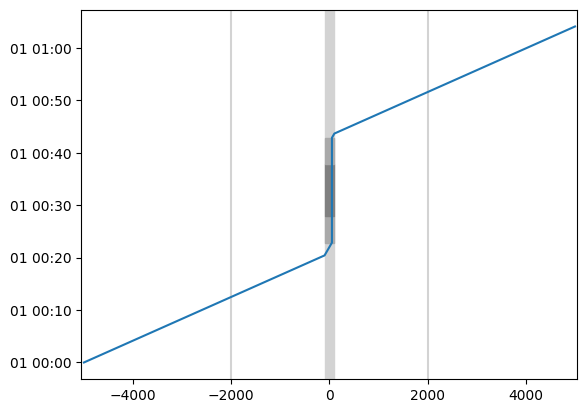

In [12]:
fig,ax = plt.subplots()

for distances,times in zip(all_distances,all_times):
    ax.plot(distances,times)

ylimmin,ylimmax = ax.get_ylim()

#Plot lock chamber
x_lock_doorsA = lock_edge_geometry.line_locate_point(transform(wgs84rad_to_wgs84eqd,lock.location_lock_doors_A))-lock_edge_geometry.length/2
x_lock_doorsB = lock_edge_geometry.line_locate_point(transform(wgs84rad_to_wgs84eqd,lock.location_lock_doors_B))-lock_edge_geometry.length/2
lock_extend_x = [x_lock_doorsA,x_lock_doorsA,x_lock_doorsB,x_lock_doorsB]
ax.fill(lock_extend_x,[ylimmin,ylimmax,ylimmax,ylimmin],color='lightgrey',zorder=0)

#Plot lock phases
for index, message_info in lock_df.iterrows():
    if message_info.Message == 'Lock doors opening stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='darkgrey',zorder=0)
    if message_info.Message == 'Lock doors closing stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='darkgrey',zorder=0)
    if message_info.Message == 'Lock chamber converting stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='grey',zorder=0)

ax.axvline(-2000,color='lightgrey',zorder=0)
ax.axvline(2000,color='lightgrey',zorder=0)
ax.set_xlim(-5050,5050);
ax.set_ylim(ylimmin,ylimmax);

In [13]:
vessel_df

,Message,Timestamp,Value,Geometry
0,Sailing from node A to node B start,2025-01-01 00:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-5000 0)
1,Sailing to waiting area start,2025-01-01 00:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-5000 0)
2,Sailing to waiting area stop,2025-01-01 00:20:25.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-99.99999999999866 0)
3,Sailing to first lock doors start,2025-01-01 00:20:25.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-99.99999999999866 0)
4,Sailing to first lock doors stop,2025-01-01 00:20:25.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-99.99999999999866 0)
5,Sailing to position in lock start,2025-01-01 00:20:25.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-99.99999999999866 0)
6,Sailing to position in lock stop,2025-01-01 00:22:50.788337,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
7,Levelling start,2025-01-01 00:27:50.788337,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
8,Levelling stop,2025-01-01 00:37:50.788337,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
9,Sailing to second lock doors start,2025-01-01 00:42:50.788337,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)


In [16]:
lock.waiting_area_A.distance_from_node

4900.0

In [20]:
test_results()